# Summary

This analysis has provided comprehensive insights into the census income dataset. Key findings include significant class imbalance, high cardinality in certain categorical features, strong predictive signals from occupation and industry codes, and the importance of using major codes over detailed recodes for better interpretability.

## 1. Import Libraries

Import all required libraries for data manipulation, visualization, and statistical analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, normaltest
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 2. Dataset Overview

Load the census income dataset and display basic information including shape, columns, and sample rows.

In [2]:
data_path = '../TakeHomeProject/census-bureau.data'
columns_path = '../TakeHomeProject/census-bureau.columns'

with open(columns_path, 'r') as f:
    columns = [line.strip() for line in f.readlines()]

df = pd.read_csv(data_path, names=columns, skipinitialspace=True)

print(f'Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns')

print('First 10 Rows:')
df.head(10)

Dataset Shape: 199,523 rows × 42 columns
First 10 Rows:


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
5,48,Private,40,10,Some college but no degree,1200,Not in universe,Married-civilian spouse present,Entertainment,Professional specialty,...,Philippines,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,95,- 50000.
6,42,Private,34,3,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
7,28,Private,4,40,High school graduate,0,Not in universe,Never married,Construction,Handlers equip cleaners etc,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,30,95,- 50000.
8,47,Local government,43,26,Some college but no degree,876,Not in universe,Married-civilian spouse present,Education,Adm support including clerical,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
9,34,Private,4,37,Some college but no degree,0,Not in universe,Married-civilian spouse present,Construction,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.


## 3. Target Label Analysis

Analyze the distribution of income labels to understand class balance and target variable characteristics.

Key Insights: Data is highly imbalanced - Experiment with SMOTE or tree based models that handle imbalance well.

Label Distribution:
  - 50000.: 187,141 (93.79%)
  50000+.: 12,382 (6.21%)

Class Imbalance Ratio: 15.11:1


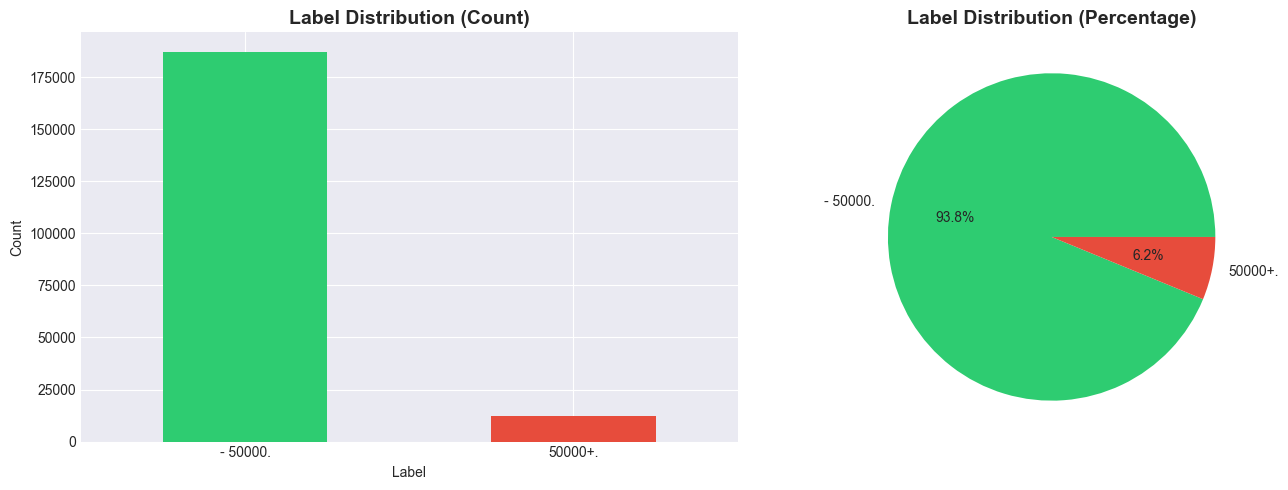

In [3]:
df['label_clean'] = df['label'].astype(str).str.strip()

label_counts = df['label_clean'].value_counts()
print('Label Distribution:')
for label, count in label_counts.items():
    pct = (count / len(df)) * 100
    print(f'  {label}: {count:,} ({pct:.2f}%)')

print(f'\nClass Imbalance Ratio: {label_counts.max() / label_counts.min():.2f}:1')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
label_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Label Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

label_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'])
axes[1].set_title('Label Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')
plt.tight_layout()
plt.show()

## 4. Missing Data Analysis

Identify and quantify missing values across all features to assess data completeness and quality.

Steps to take:
- "?" → Genuine missing (replace with "Unknown")
- True NaN → Replace with "Unknown"

Columns with Missing Values: 9/43

                        Column  Null Count  Question Mark  Total Missing  Missing %
  migration code-change in msa           0          99696          99696  49.967172
  migration code-change in reg           0          99696          99696  49.967172
migration code-move within reg           0          99696          99696  49.967172
 migration prev res in sunbelt           0          99696          99696  49.967172
       country of birth father           0           6713           6713   3.364524
       country of birth mother           0           6119           6119   3.066814
         country of birth self           0           3393           3393   1.700556
               hispanic origin         874              0            874   0.438045
   state of previous residence           0            708            708   0.354846


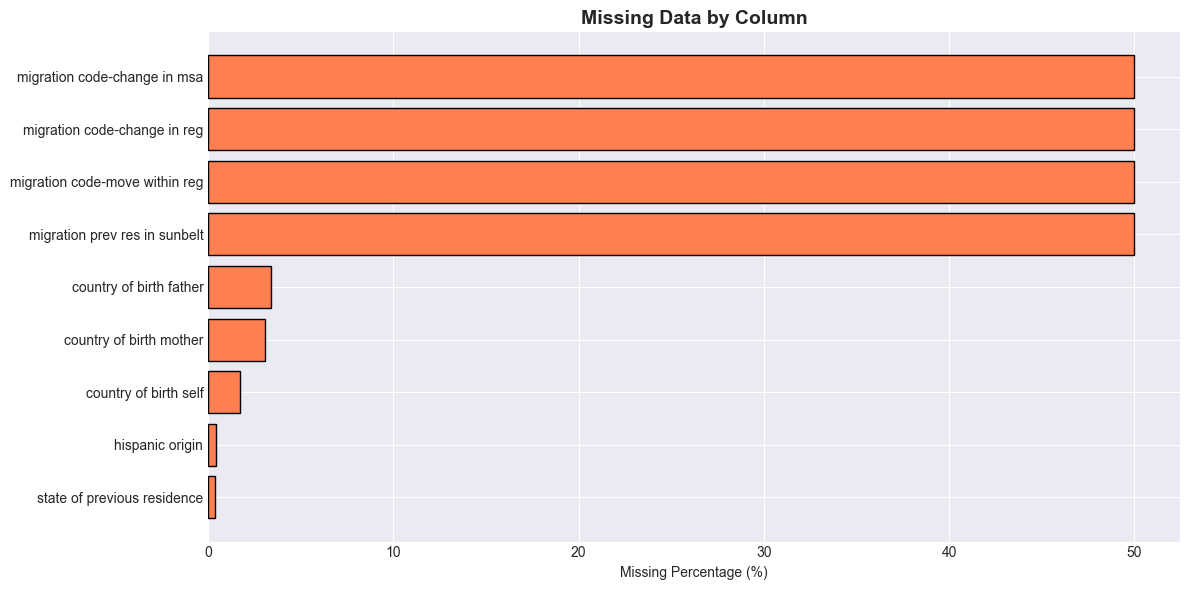

In [4]:
missing_info = []
for col in df.columns:
    null_count = df[col].isnull().sum()
    question_count = (df[col].astype(str).str.strip() == '?').sum()
    total_missing = null_count + question_count
    missing_pct = (total_missing / len(df)) * 100
    
    if total_missing > 0:
        missing_info.append({
            'Column': col,
            'Null Count': null_count,
            'Question Mark': question_count,
            'Total Missing': total_missing,
            'Missing %': missing_pct
        })

if missing_info:
    missing_df = pd.DataFrame(missing_info).sort_values('Missing %', ascending=False)
    print(f'Columns with Missing Values: {len(missing_df)}/{len(df.columns)}')
    print(f'\n{missing_df.to_string(index=False)}')
    
    plt.figure(figsize=(12, 6))
    plt.barh(missing_df['Column'], missing_df['Missing %'], color='coral', edgecolor='black')
    plt.xlabel('Missing Percentage (%)')
    plt.title('Missing Data by Column', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print('No missing values found in the dataset.')

## 5. Data Quality Assessment

Evaluate overall data quality by examining unique values, data types, and potential issues across all columns.

Key Insights: 
- Numeric features might have to be scaled - need to be analyzed further.
- Categorical data with low cardinality - one hot encoding
- Categorical data with high cardinality - target/categorical encoding


In [5]:
quality_report = []
for col in df.columns:
    col_data = df[col]
    unique_count = col_data.nunique()
    missing = col_data.isnull().sum() + (col_data.astype(str).str.strip() == '?').sum()
    missing_pct = (missing / len(df)) * 100
    
    quality_report.append({
        'Column': col,
        'Data Type': col_data.dtype,
        'Unique Values': unique_count,
        'Missing %': f'{missing_pct:.2f}%',
        'Cardinality': 'High' if unique_count > 50 else 'Medium' if unique_count > 10 else 'Low'
    })

quality_df = pd.DataFrame(quality_report)
print('Data Quality Summary:')
print(quality_df.to_string(index=False))

Data Quality Summary:
                                    Column Data Type  Unique Values Missing % Cardinality
                                       age     int64             91     0.00%        High
                           class of worker    object              9     0.00%         Low
                  detailed industry recode     int64             52     0.00%        High
                detailed occupation recode     int64             47     0.00%      Medium
                                 education    object             17     0.00%      Medium
                             wage per hour     int64           1240     0.00%        High
                enroll in edu inst last wk    object              3     0.00%         Low
                              marital stat    object              7     0.00%         Low
                       major industry code    object             24     0.00%      Medium
                     major occupation code    object             15     0.00% 

## 6. Column Types Identification

Classify columns into numeric and categorical types for appropriate analysis methods.

In [6]:
numeric_cols = ['age', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer', 'weeks worked in year']
categorical_cols = [col for col in df.columns if col not in numeric_cols + ['label', 'label_clean']]

print(f'Numeric Columns ({len(numeric_cols)}): {numeric_cols}')
print(f'\nCategorical Columns ({len(categorical_cols)}):')
for i, col in enumerate(categorical_cols, 1):
    print(f'  {i:2d}. {col}')

print(f'\nNote: detailed industry recode and detailed occupation recode are categorical (encoded numeric codes without data dictionary)')

Numeric Columns (7): ['age', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer', 'weeks worked in year']

Categorical Columns (34):
   1. class of worker
   2. detailed industry recode
   3. detailed occupation recode
   4. education
   5. enroll in edu inst last wk
   6. marital stat
   7. major industry code
   8. major occupation code
   9. race
  10. hispanic origin
  11. sex
  12. member of a labor union
  13. reason for unemployment
  14. full or part time employment stat
  15. tax filer stat
  16. region of previous residence
  17. state of previous residence
  18. detailed household and family stat
  19. detailed household summary in household
  20. weight
  21. migration code-change in msa
  22. migration code-change in reg
  23. migration code-move within reg
  24. live in this house 1 year ago
  25. migration prev res in sunbelt
  26. family members under 18
  27. country of birth father
  28. country of birth mothe

## 6A. Weight Column Analysis

Analyze the weight column (instance weights) to understand its distribution and determine whether to use it as a feature or apply it as sample weights during modeling.

Insights:

- Survey weight represents sampling methodology, not individual characteristics
- High cardinality (99,800 unique values) makes it unsuitable for direct modeling
- Not predictive of income - it's a statistical adjustment factor
- DROP weight column from features
- USE as sample_weight parameter during model training (experiment)
- Helps model account for survey sampling bias
- Ensures weighted statistics match population-level estimates

WEIGHT COLUMN ANALYSIS


Basic Statistics:
Unique values: 99,800
Total records: 199,523
Data type: float64

Range Statistics:
Minimum: 37.87
Maximum: 18,656.30
Mean: 1,740.38
Median: 1,618.31
Std Dev: 993.77

Percentiles:
  1th percentile: 241.26
  5th percentile: 395.34
  10th percentile: 596.24
  25th percentile: 1,061.62
  50th percentile: 1,618.31
  75th percentile: 2,188.61
  90th percentile: 3,059.82
  95th percentile: 3,585.91
  99th percentile: 4,778.25

Weight Distribution by Income Label:
              count         mean   median           sum
label_clean                                            
- 50000.     187141  1736.683288  1612.93  3.250046e+08
50000+.       12382  1796.256279  1684.10  2.224125e+07

Top 10 Most Common Weight Values:
  1,601.40: 32 records (0.02%)
  753.23: 32 records (0.02%)
  1,191.21: 32 records (0.02%)
  1,787.34: 32 records (0.02%)
  1,317.51: 31 records (0.02%)
  707.90: 31 records (0.02%)
  1,070.15: 30 records (0.02%)
  1,009.39: 28 records (

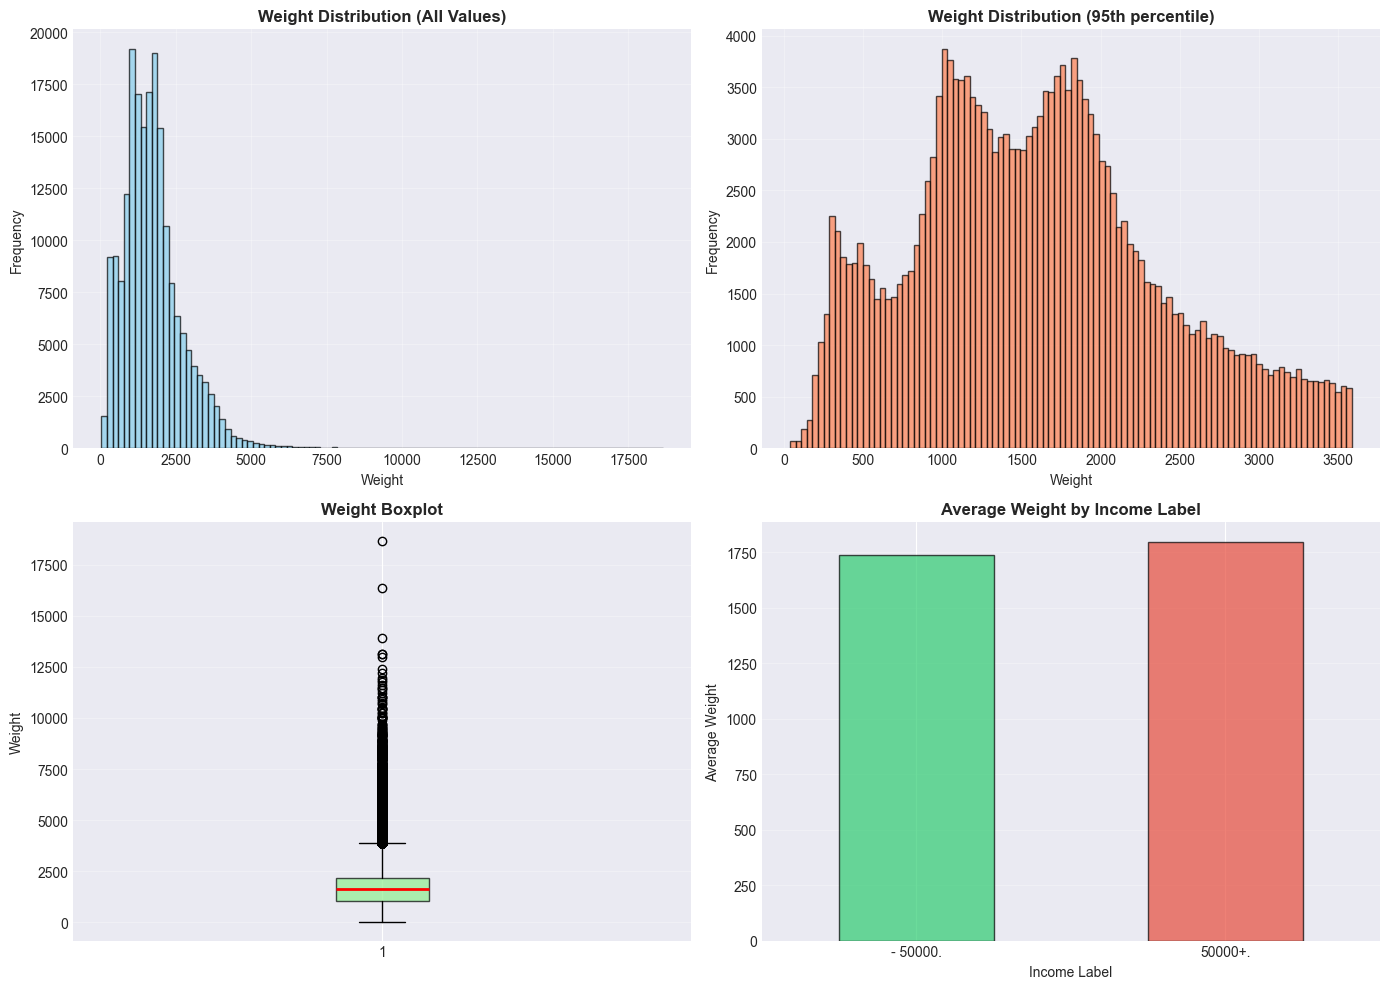

In [7]:
if 'weight' in df.columns:
    weight_col = df['weight']
    
    print('WEIGHT COLUMN ANALYSIS\n')
    print(f'\nBasic Statistics:')
    print(f'Unique values: {weight_col.nunique():,}')
    print(f'Total records: {len(weight_col):,}')
    print(f'Data type: {weight_col.dtype}')
    
    print(f'\nRange Statistics:')
    print(f'Minimum: {weight_col.min():,.2f}')
    print(f'Maximum: {weight_col.max():,.2f}')
    print(f'Mean: {weight_col.mean():,.2f}')
    print(f'Median: {weight_col.median():,.2f}')
    print(f'Std Dev: {weight_col.std():,.2f}')
    
    print(f'\nPercentiles:')
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    for p in percentiles:
        val = weight_col.quantile(p/100)
        print(f'  {p}th percentile: {val:,.2f}')
    
    print(f'\nWeight Distribution by Income Label:')
    weight_by_label = df.groupby('label_clean')['weight'].agg(['count', 'mean', 'median', 'sum'])
    print(weight_by_label.to_string())
    
    print(f'\nTop 10 Most Common Weight Values:')
    top_weights = weight_col.value_counts().head(10)
    for weight, count in top_weights.items():
        pct = (count / len(weight_col)) * 100
        print(f'  {weight:,.2f}: {count:,} records ({pct:.2f}%)')
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].hist(weight_col, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Weight Distribution (All Values)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Weight')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(alpha=0.3)
    
    weight_trimmed = weight_col[weight_col <= weight_col.quantile(0.95)]
    axes[0, 1].hist(weight_trimmed, bins=100, color='coral', edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Weight Distribution (95th percentile)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Weight')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(alpha=0.3)
    
    axes[1, 0].boxplot(weight_col, vert=True, patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7),
                       medianprops=dict(color='red', linewidth=2))
    axes[1, 0].set_title('Weight Boxplot', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Weight')
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    weight_by_label_mean = df.groupby('label_clean')['weight'].mean()
    weight_by_label_mean.plot(kind='bar', ax=axes[1, 1], color=['#2ecc71', '#e74c3c'], 
                               edgecolor='black', alpha=0.7)
    axes[1, 1].set_title('Average Weight by Income Label', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Income Label')
    axes[1, 1].set_ylabel('Average Weight')
    axes[1, 1].tick_params(axis='x', rotation=0)
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 7. Numeric Feature Analysis

Compute descriptive statistics for all numeric features to understand their distributions and ranges.

Insights:

Need to scale these 4 numeric features for better model performance
   - wage per hour
   - capital gains
   - capital losses
   - dividends from stocks

Numeric Features - Descriptive Statistics:
                                    count        mean          std  min   25%   50%   75%      max
age                              199523.0   34.494199    22.310895  0.0  15.0  33.0  50.0     90.0
wage per hour                    199523.0   55.426908   274.896454  0.0   0.0   0.0   0.0   9999.0
capital gains                    199523.0  434.718990  4697.531280  0.0   0.0   0.0   0.0  99999.0
capital losses                   199523.0   37.313788   271.896428  0.0   0.0   0.0   0.0   4608.0
dividends from stocks            199523.0  197.529533  1984.163658  0.0   0.0   0.0   0.0  99999.0
num persons worked for employer  199523.0    1.956180     2.365126  0.0   0.0   1.0   4.0      6.0
weeks worked in year             199523.0   23.174897    24.411488  0.0   0.0   8.0  52.0     52.0


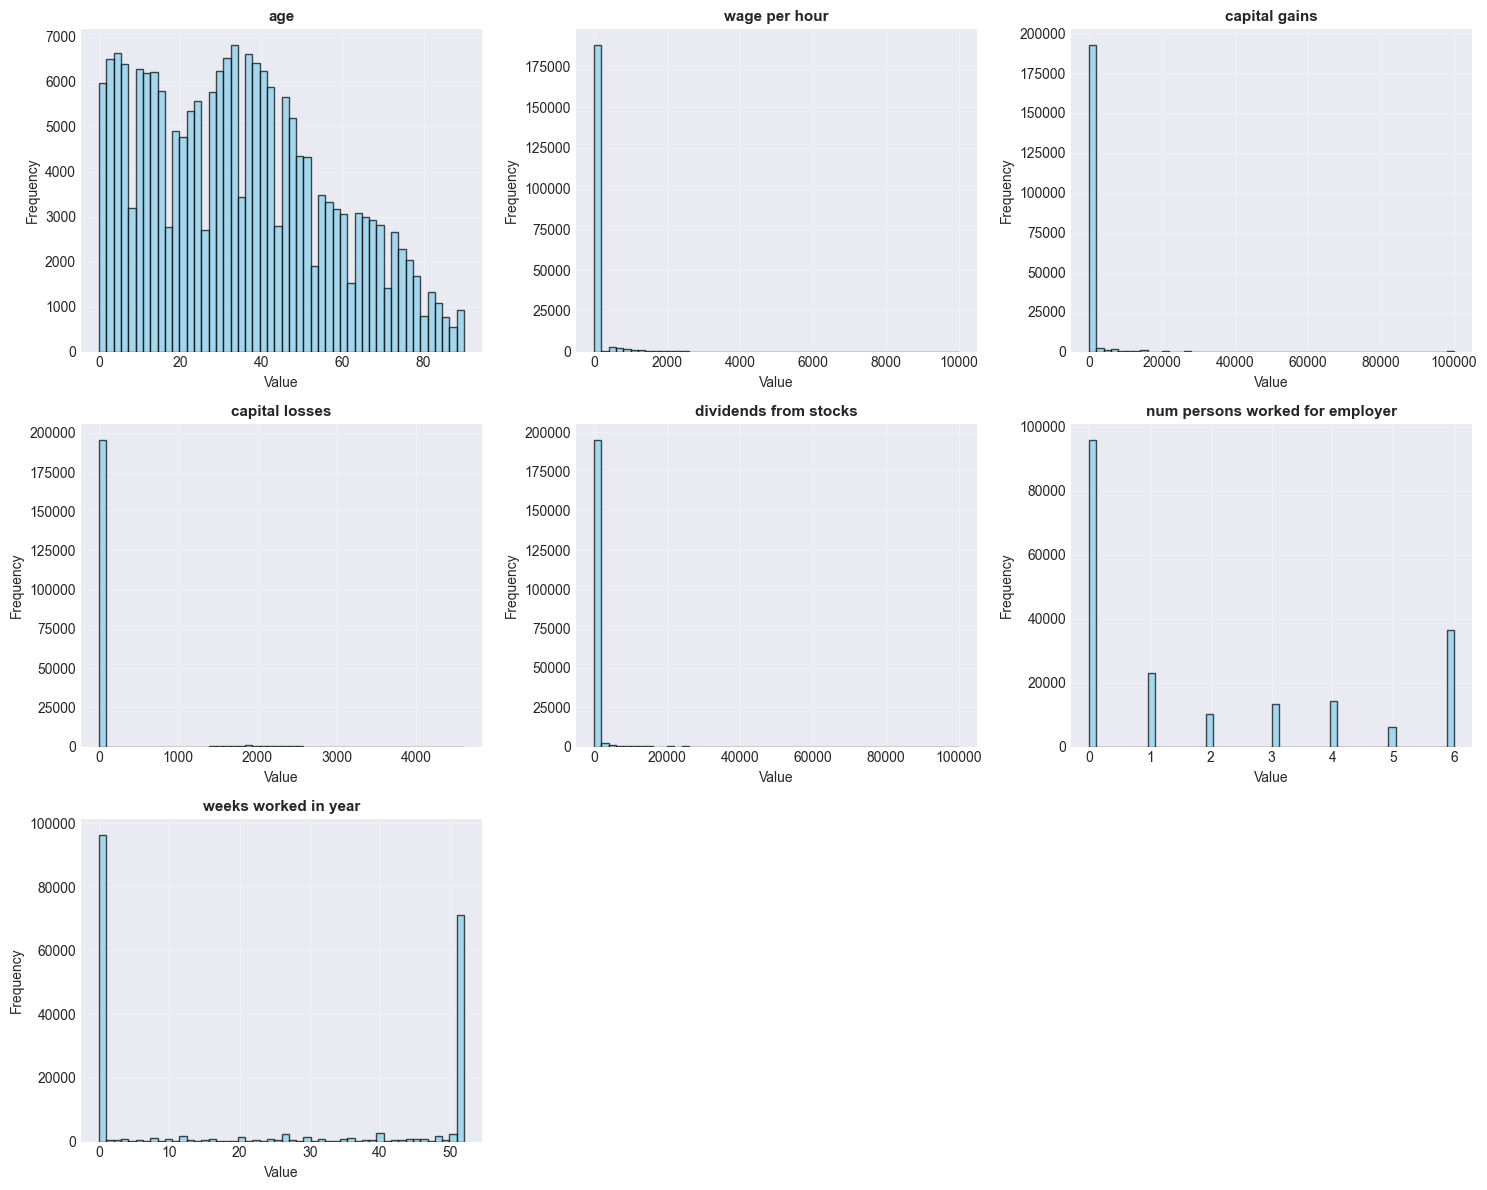

In [8]:
df_numeric = df[numeric_cols].copy()

print('Numeric Features - Descriptive Statistics:')
print(df_numeric.describe().T.to_string())

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    axes[idx].hist(df_numeric[col].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(col, fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Boxplots for Numeric Features

Visualize numeric feature distributions using boxplots to identify outliers and understand spread.

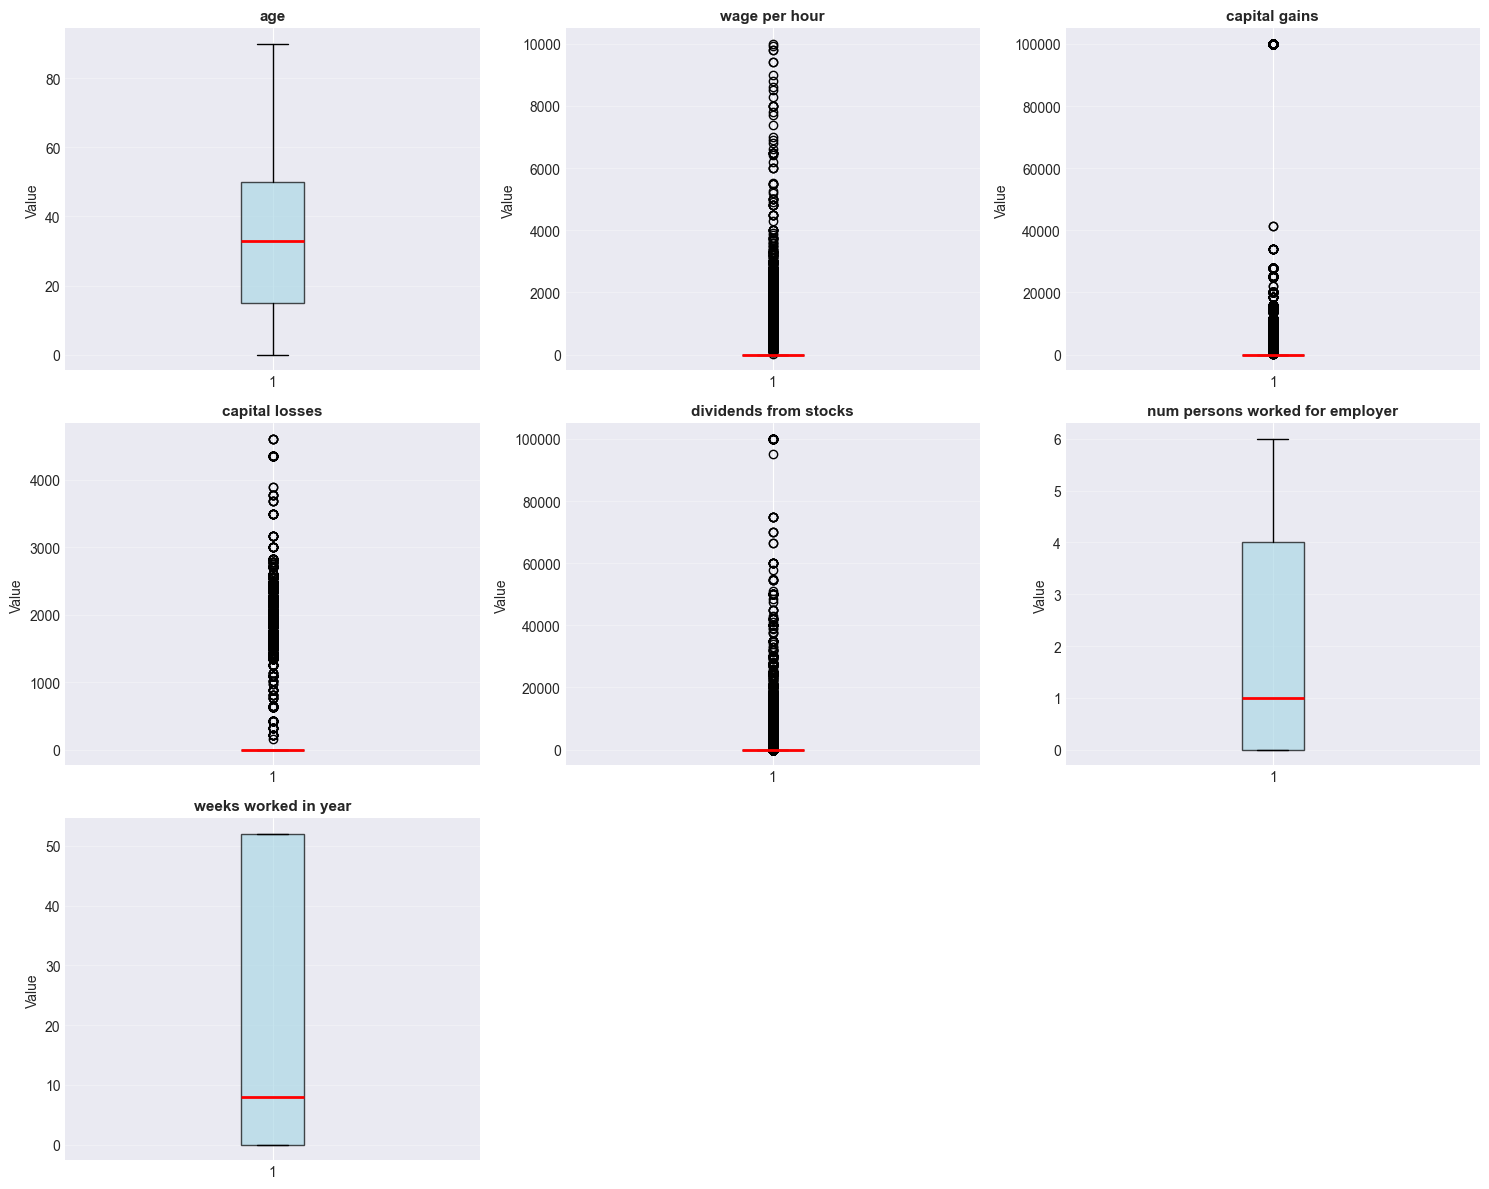

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    data_to_plot = df_numeric[col].dropna()
    axes[idx].boxplot(data_to_plot, vert=True, patch_artist=True,
                      boxprops=dict(facecolor='lightblue', alpha=0.7),
                      medianprops=dict(color='red', linewidth=2))
    axes[idx].set_title(col, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(alpha=0.3, axis='y')

for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 8. Correlation Analysis

Analyze correlations between numeric features to identify relationships and potential multicollinearity.

Key Insight: No multicollinear features detected (greater than 0.8)

Correlation Matrix:
                                      age  wage per hour  capital gains  capital losses  dividends from stocks  num persons worked for employer  weeks worked in year
age                              1.000000       0.036938       0.053590        0.063351               0.104976                         0.140887              0.206181
wage per hour                    0.036938       1.000000      -0.001082        0.010993              -0.005731                         0.191543              0.195687
capital gains                    0.053590      -0.001082       1.000000       -0.012700               0.131476                         0.058015              0.083549
capital losses                   0.063351       0.010993      -0.012700        1.000000               0.042427                         0.084255              0.100762
dividends from stocks            0.104976      -0.005731       0.131476        0.042427               1.000000                         0.007206       

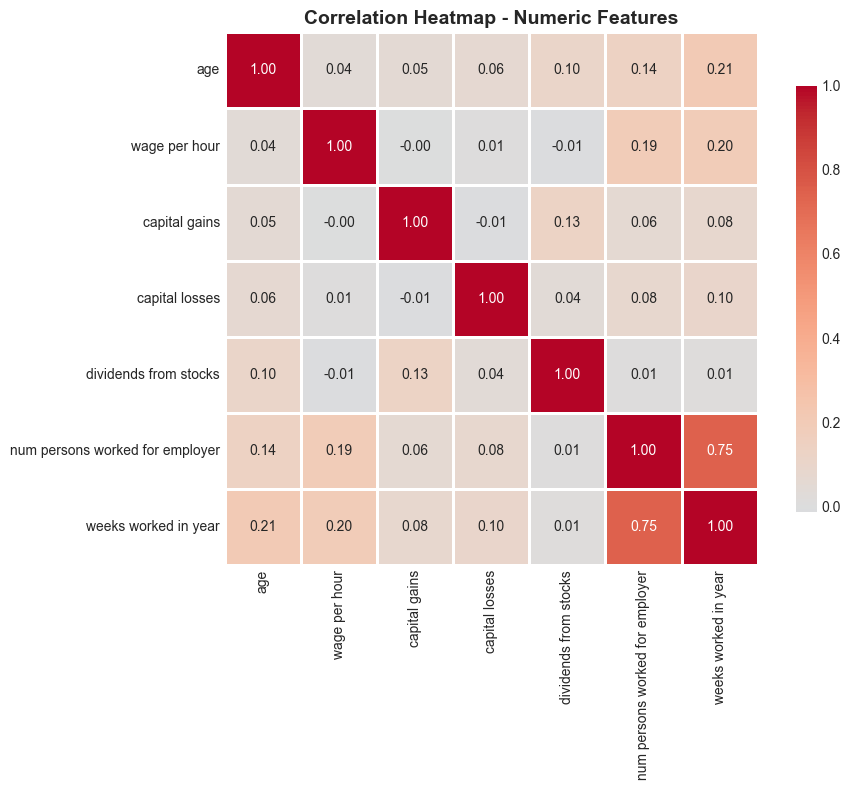

In [10]:
correlation_matrix = df_numeric.corr()

print('Correlation Matrix:')
print(correlation_matrix.to_string())

corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append({
            'Feature 1': correlation_matrix.columns[i],
            'Feature 2': correlation_matrix.columns[j],
            'Correlation': correlation_matrix.iloc[i, j]
        })

corr_df = pd.DataFrame(corr_pairs).sort_values('Correlation', key=abs, ascending=False)
print('\nTop Correlations:')
print(corr_df.head(15).to_string(index=False))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap - Numeric Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Feature vs Label Analysis

Compare numeric feature distributions across income labels using boxplots to identify discriminative features.

Key Insights: 
- '>50K' correlates with older age, full-year work, higher employer-size bucket, and presence/size of investment income (gains/dividends). Can compare the with model feature importance later on for interpretability or marketing strategies.

- Several variables are zero-inflated, so adding >0 indicators or log1p scaling is plausible.

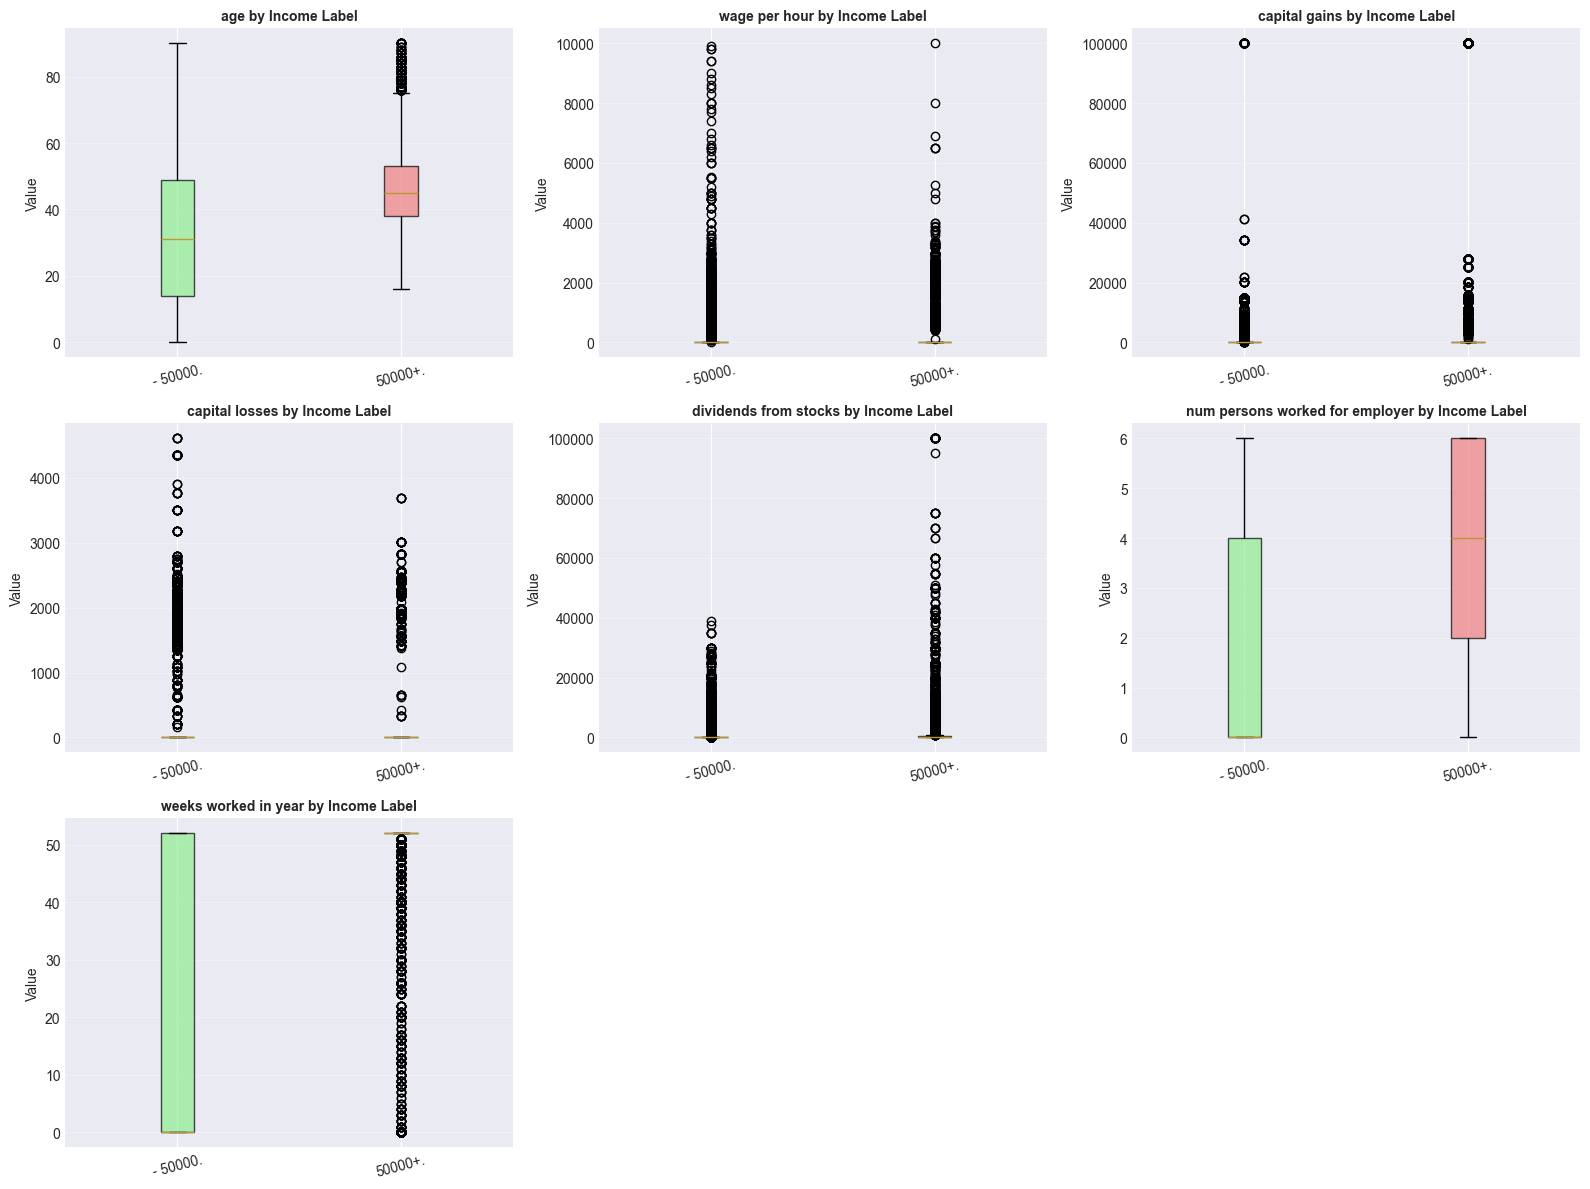

In [11]:
df_numeric_labeled = df_numeric.copy()
df_numeric_labeled['label'] = df['label_clean']

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    data_to_plot = [df_numeric_labeled[df_numeric_labeled['label'] == label][col].dropna() 
                    for label in df_numeric_labeled['label'].unique()]
    
    bp = axes[idx].boxplot(data_to_plot, labels=df_numeric_labeled['label'].unique(),
                           patch_artist=True)
    
    for patch, color in zip(bp['boxes'], ['lightgreen', 'lightcoral']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[idx].set_title(f'{col} by Income Label', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(alpha=0.3, axis='y')
    axes[idx].tick_params(axis='x', rotation=15)

for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 10. Categorical Columns Analysis

### Categorical Feature Visualizations

Key Insights:

- Several employment-related variables contain a large ‘Not in universe’ category. Maybe we should retain ‘Not in universe’ as a valid category rather than treating it like missing value. (Need further analysis)

- The dataset is demographically imbalanced across race and Hispanic-origin subcategories, suggesting that rare categories may require careful encoding (e.g., frequency encoding).

- Education and marital status show concentrated distributions (e.g., high school graduates/children; never married/married), can use them later for explaining income differences when analyzed against the target label in task2.

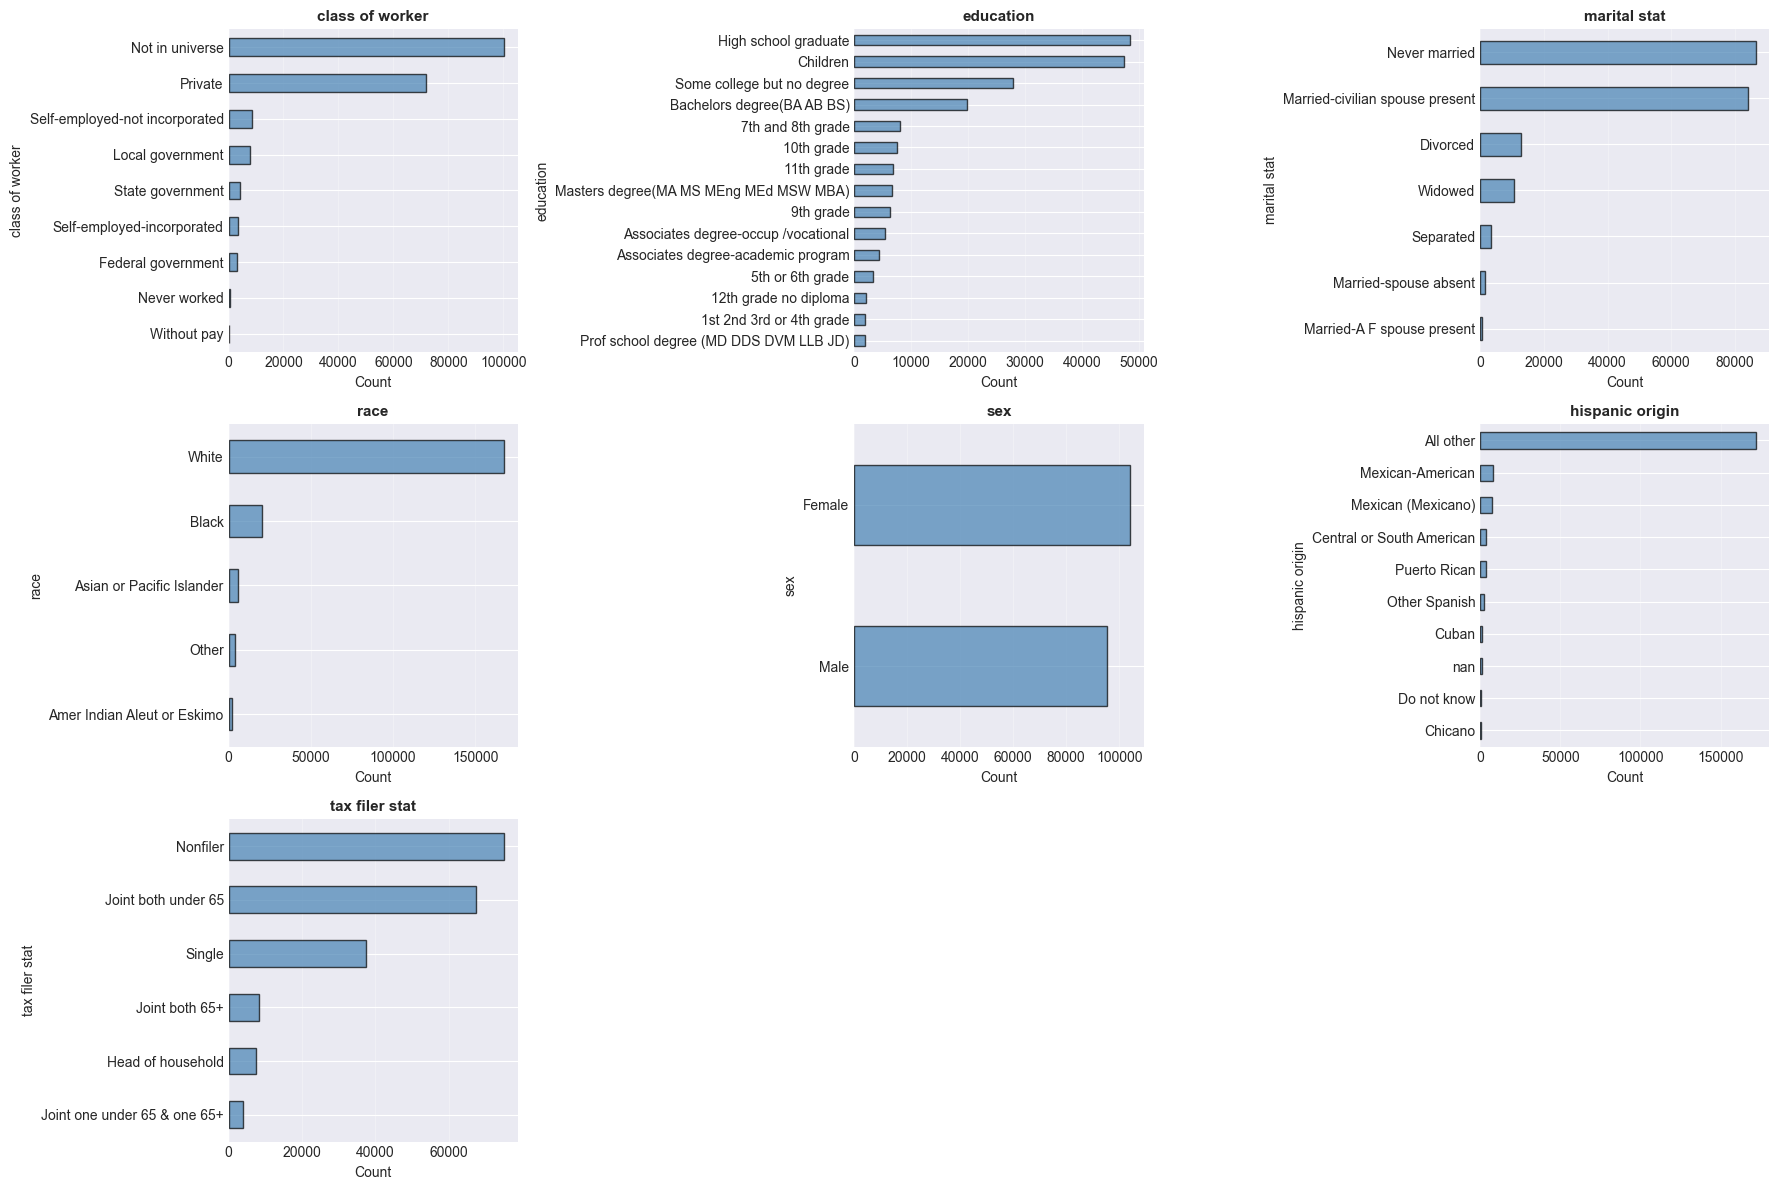

In [12]:
cols_to_plot = ['class of worker', 'education', 'marital stat', 'race', 'sex', 'hispanic origin', 'tax filer stat']

n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(cols_to_plot):
    cleaned = df[col].astype(str).str.strip()
    value_counts = cleaned[cleaned != '?'].value_counts()
    
    if len(value_counts) <= 15:
        value_counts.plot(kind='barh', ax=axes[idx], color='steelblue', edgecolor='black', alpha=0.7)
    else:
        value_counts.head(15).plot(kind='barh', ax=axes[idx], color='steelblue', edgecolor='black', alpha=0.7)
    
    axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Count')
    axes[idx].invert_yaxis()
    axes[idx].grid(alpha=0.3, axis='x')

for idx in range(len(cols_to_plot), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Categorical Features vs Target (Chi-Square Test)

Perform chi-square tests to statistically validate relationships between categorical features and income labels.

Key Insights:

Occupation and education show the strongest associations with income class, followed by industry, class of worker, and tax filing status. Can be used for segmentation in task 2. (Maybe demographic-economic segmentation?)

In [13]:
chi_square_results = []

for col in categorical_cols[:15]:
    cleaned = df[col].astype(str).str.strip()
    contingency_table = pd.crosstab(cleaned, df['label_clean'])
    
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    
    chi_square_results.append({
        'Feature': col,
        'Chi-Square': chi2,
        'p-value': p_value,
        'Cramers V': cramers_v,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

chi_df = pd.DataFrame(chi_square_results).sort_values('Cramers V', ascending=False)
print('Chi-Square Test Results:')
print(chi_df.to_string(index=False))

Chi-Square Test Results:
                          Feature   Chi-Square       p-value  Cramers V Significant
       detailed occupation recode 38313.823147  0.000000e+00   0.438209         Yes
                        education 30322.049718  0.000000e+00   0.389837         Yes
            major occupation code 26765.882894  0.000000e+00   0.366264         Yes
         detailed industry recode 17123.857345  0.000000e+00   0.292957         Yes
              major industry code 15404.367654  0.000000e+00   0.277860         Yes
                  class of worker 13542.953109  0.000000e+00   0.260531         Yes
                   tax filer stat 10484.359945  0.000000e+00   0.229232         Yes
                     marital stat  7794.867355  0.000000e+00   0.197655         Yes
full or part time employment stat  5098.018910  0.000000e+00   0.159847         Yes
                              sex  4955.014385  0.000000e+00   0.157589         Yes
          member of a labor union  1122.302343 1.97

## 11. Household & Family Structure Analysis

Examine household composition and family structure features to understand their relationship with income. These features provide context about living arrangements and family responsibilities. Will help with task 2 for segmentation.

Key Insights:
- Household role and labor-force attachment create clear, interpretable segments.
- These segments align with income likelihood and will help with segmentation and targeting strategy.
- Survey weights allow translating segments into population-level estimates for marketing reach.

DETAILED HOUSEHOLD AND FAMILY STAT

Distribution:
  Householder: 53,248 (26.69%)
  Child <18 never marr not in subfamily: 50,326 (25.22%)
  Spouse of householder: 41,695 (20.90%)
  Nonfamily householder: 22,213 (11.13%)
  Child 18+ never marr Not in a subfamily: 12,030 (6.03%)
  Secondary individual: 6,122 (3.07%)
  Other Rel 18+ ever marr not in subfamily: 1,956 (0.98%)
  Grandchild <18 never marr child of subfamily RP: 1,868 (0.94%)
  Other Rel 18+ never marr not in subfamily: 1,728 (0.87%)
  Grandchild <18 never marr not in subfamily: 1,066 (0.53%)
  Child 18+ ever marr Not in a subfamily: 1,013 (0.51%)
  Child under 18 of RP of unrel subfamily: 732 (0.37%)
  RP of unrelated subfamily: 685 (0.34%)
  Child 18+ ever marr RP of subfamily: 671 (0.34%)
  Other Rel <18 never marr child of subfamily RP: 656 (0.33%)
  Other Rel 18+ ever marr RP of subfamily: 656 (0.33%)
  Other Rel 18+ spouse of subfamily RP: 638 (0.32%)
  Child 18+ never marr RP of subfamily: 589 (0.30%)
  Other Rel <18 ne

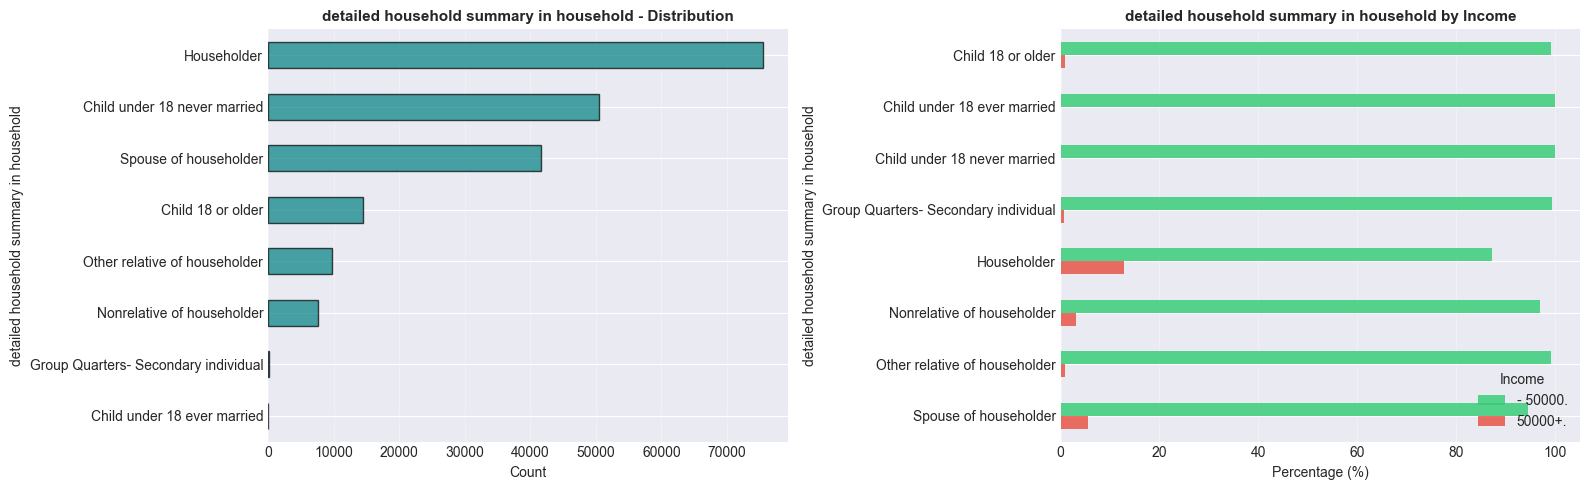

MEMBER OF A LABOR UNION

Distribution:
  Not in universe: 180,459 (90.45%)
  No: 16,034 (8.04%)
  Yes: 3,030 (1.52%)

Income Distribution:
label_clean               - 50000.    50000+.
member of a labor union                      
No                       88.636647  11.363353
Not in universe          94.376562   5.623438
Yes                      86.402640  13.597360


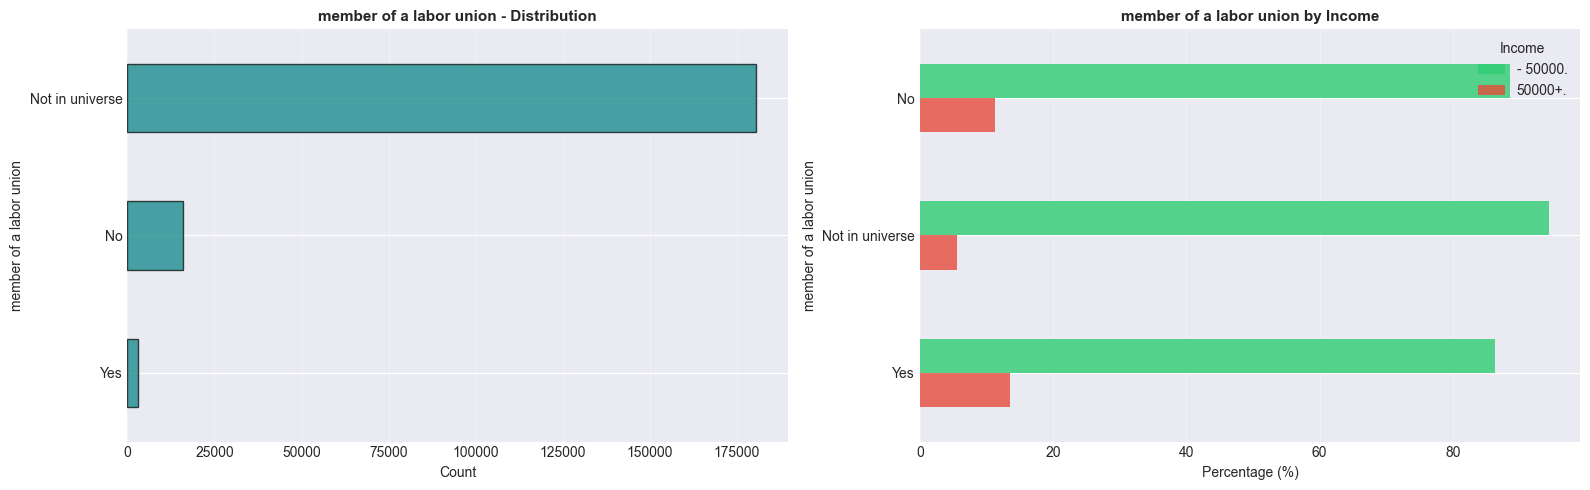

REASON FOR UNEMPLOYMENT

Distribution:
  Not in universe: 193,453 (96.96%)
  Other job loser: 2,038 (1.02%)
  Re-entrant: 2,019 (1.01%)
  Job loser - on layoff: 976 (0.49%)
  Job leaver: 598 (0.30%)
  New entrant: 439 (0.22%)

Income Distribution:
label_clean               - 50000.   50000+.
reason for unemployment                     
Job leaver               95.986622  4.013378
Job loser - on layoff    97.745902  2.254098
New entrant              99.544419  0.455581
Not in universe          93.687356  6.312644
Other job loser          95.142296  4.857704
Re-entrant               98.860822  1.139178


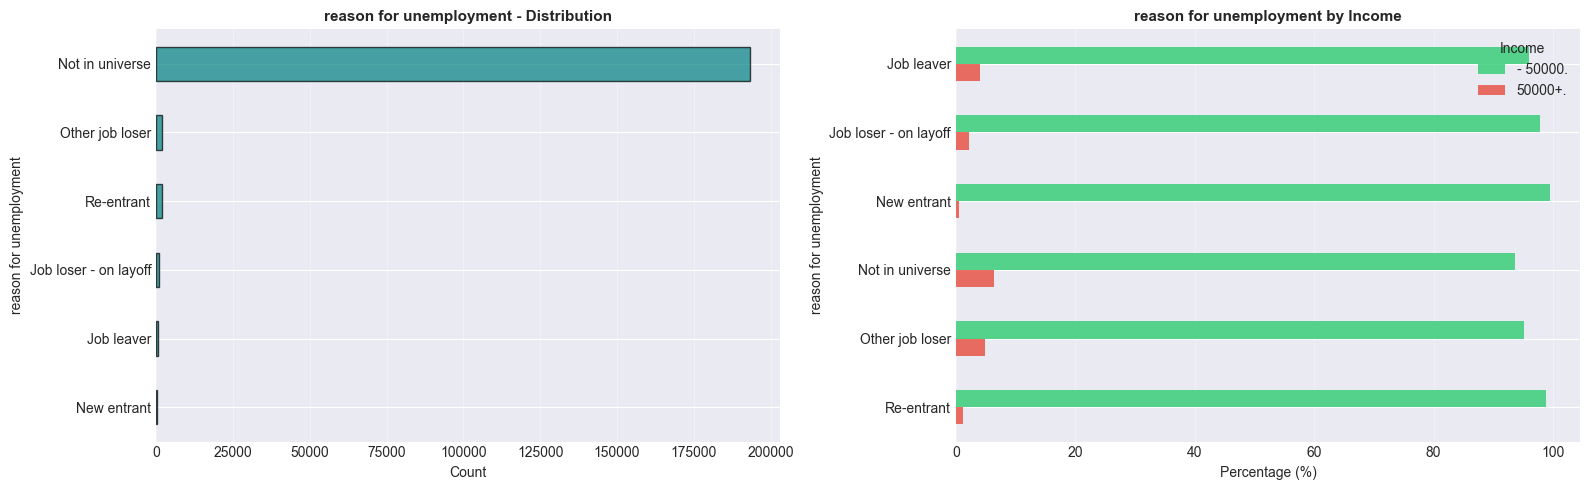

FULL OR PART TIME EMPLOYMENT STAT

Distribution:
  Children or Armed Forces: 123,769 (62.03%)
  Full-time schedules: 40,736 (20.42%)
  Not in labor force: 26,808 (13.44%)
  PT for non-econ reasons usually FT: 3,322 (1.66%)
  Unemployed full-time: 2,311 (1.16%)
  PT for econ reasons usually PT: 1,209 (0.61%)
  Unemployed part- time: 843 (0.42%)
  PT for econ reasons usually FT: 525 (0.26%)

Income Distribution:
label_clean                          - 50000.    50000+.
full or part time employment stat                       
Children or Armed Forces            95.254062   4.745938
Full-time schedules                 86.827376  13.172624
Not in labor force                  98.276634   1.723366
PT for econ reasons usually FT      94.095238   5.904762
PT for econ reasons usually PT      87.179487  12.820513
PT for non-econ reasons usually FT  88.169777  11.830223
Unemployed full-time                96.408481   3.591519
Unemployed part- time               97.864769   2.135231


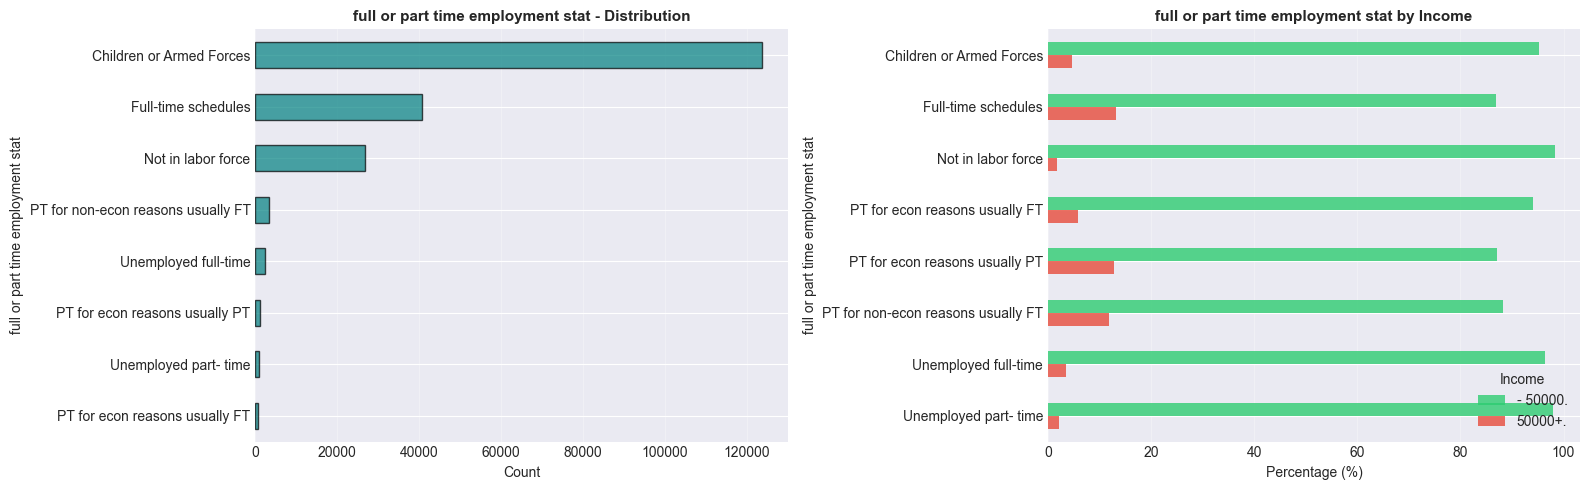

In [14]:
household_cols = ['detailed household and family stat', 'detailed household summary in household', 
                  'member of a labor union', 'reason for unemployment', 'full or part time employment stat']

for col in household_cols:
    if col in df.columns:
        print(f'{col.upper()}')
     
        cleaned = df[col].astype(str).str.strip()
        household_counts = cleaned[cleaned != '?'].value_counts()
        
        print(f'\nDistribution:')
        for cat, count in household_counts.items():
            pct = (count / len(cleaned[cleaned != '?'])) * 100
            print(f'  {cat}: {count:,} ({pct:.2f}%)')
        
        print(f'\nIncome Distribution:')
        crosstab = pd.crosstab(cleaned, df['label_clean'], normalize='index') * 100
        print(crosstab.to_string())
        
        if len(household_counts) <= 15:
            fig, axes = plt.subplots(1, 2, figsize=(16, 5))
            household_counts.plot(kind='barh', ax=axes[0], color='teal', edgecolor='black', alpha=0.7)
            axes[0].set_title(f'{col} - Distribution', fontsize=11, fontweight='bold')
            axes[0].set_xlabel('Count')
            axes[0].invert_yaxis()
            axes[0].grid(alpha=0.3, axis='x')
            
            crosstab.plot(kind='barh', stacked=False, ax=axes[1], color=['#2ecc71', '#e74c3c'], alpha=0.8)
            axes[1].set_title(f'{col} by Income', fontsize=11, fontweight='bold')
            axes[1].set_xlabel('Percentage (%)')
            axes[1].legend(title='Income')
            axes[1].invert_yaxis()
            axes[1].grid(alpha=0.3, axis='x')
            plt.tight_layout()
            plt.show()

## 12. Geographic Feature Analysis

Analyze regional and migration patterns to understand geographic influences on income levels. Will also help with task 2 segmentation if I decide to go with geographic based segmentation.

Key Insights:
- Geographic segmentation based on prior-residence and migration variables is limited in this dataset because the vast majority of records are coded as “Not in universe” (≈92% for previous state/region). 
- These fields describe previous residence and mobility patterns rather than current location, making them poorly aligned with marketing geotargeting. 
- Among the remaining mover subset, category counts are sparse and high-income rates vary only modestly, indicating limited segmentation lift.
- Should go with demographic based segmentation instead of geo.

In [15]:
geo_columns = ['state of previous residence', 'region of previous residence', 'migration code-change in msa', 
               'migration code-change in reg', 'migration code-move within reg']

for col in geo_columns:
    if col in df.columns:

        print(f'{col.upper()}')

        cleaned = df[col].astype(str).str.strip()
        value_counts = cleaned[cleaned != '?'].value_counts()
        
        print(f'\nTop 10 Categories:')
        for cat, count in value_counts.head(10).items():
            pct = (count / len(cleaned[cleaned != '?'])) * 100
            print(f'  {cat}: {count:,} ({pct:.2f}%)')
        
        region_income = []
        for region in value_counts.head(10).index:
            subset = df[cleaned == region]
            high_income = subset['label_clean'].str.contains('50000\+', regex=True).sum()
            high_income_pct = (high_income / len(subset)) * 100
            region_income.append({'Category': region[:40], 'High Income %': high_income_pct})
        
        region_df = pd.DataFrame(region_income).sort_values('High Income %', ascending=False)
        print(f'\nHigh Income % by Category:')
        print(region_df.to_string(index=False))

STATE OF PREVIOUS RESIDENCE

Top 10 Categories:
  Not in universe: 183,750 (92.42%)
  California: 1,714 (0.86%)
  Utah: 1,063 (0.53%)
  Florida: 849 (0.43%)
  North Carolina: 812 (0.41%)
  Abroad: 671 (0.34%)
  Oklahoma: 626 (0.31%)
  Minnesota: 576 (0.29%)
  Indiana: 533 (0.27%)
  North Dakota: 499 (0.25%)

High Income % by Category:
       Category  High Income %
Not in universe       6.402177
 North Carolina       5.295567
     California       3.908985
   North Dakota       3.607214
        Florida       3.533569
      Minnesota       3.472222
         Abroad       3.427720
       Oklahoma       3.194888
        Indiana       3.001876
           Utah       2.916275
REGION OF PREVIOUS RESIDENCE

Top 10 Categories:
  Not in universe: 183,750 (92.09%)
  South: 4,889 (2.45%)
  West: 4,074 (2.04%)
  Midwest: 3,575 (1.79%)
  Northeast: 2,705 (1.36%)
  Abroad: 530 (0.27%)

High Income % by Category:
       Category  High Income %
Not in universe       6.402177
      Northeast       5.4343

## 13. Not In Universe (NIU) Analysis

Analyze the "Not in universe" pattern across features which indicates questions not applicable to certain respondents. This helps understand data sparsity and question relevance.

Key Insight: Features with high NIU percentages may have limited applicability and should be carefully considered during feature engineering.

Columns with "Not in universe" values: 15

                                    Column  NIU Count     NIU %
fill inc questionnaire for veteran's admin     197539 99.005628
                   reason for unemployment     193453 96.957744
                enroll in edu inst last wk     186943 93.694962
              region of previous residence     183750 92.094646
               state of previous residence     183750 92.094646
                   member of a labor union     180459 90.445212
                   family members under 18     144232 72.288408
             live in this house 1 year ago     101212 50.726984
                       major industry code     100684 50.462353
                     major occupation code     100684 50.462353
                           class of worker     100245 50.242328
             migration prev res in sunbelt      84054 42.127474
              migration code-change in msa       1516  0.759812
              migration code-change in reg       1516  0.7598

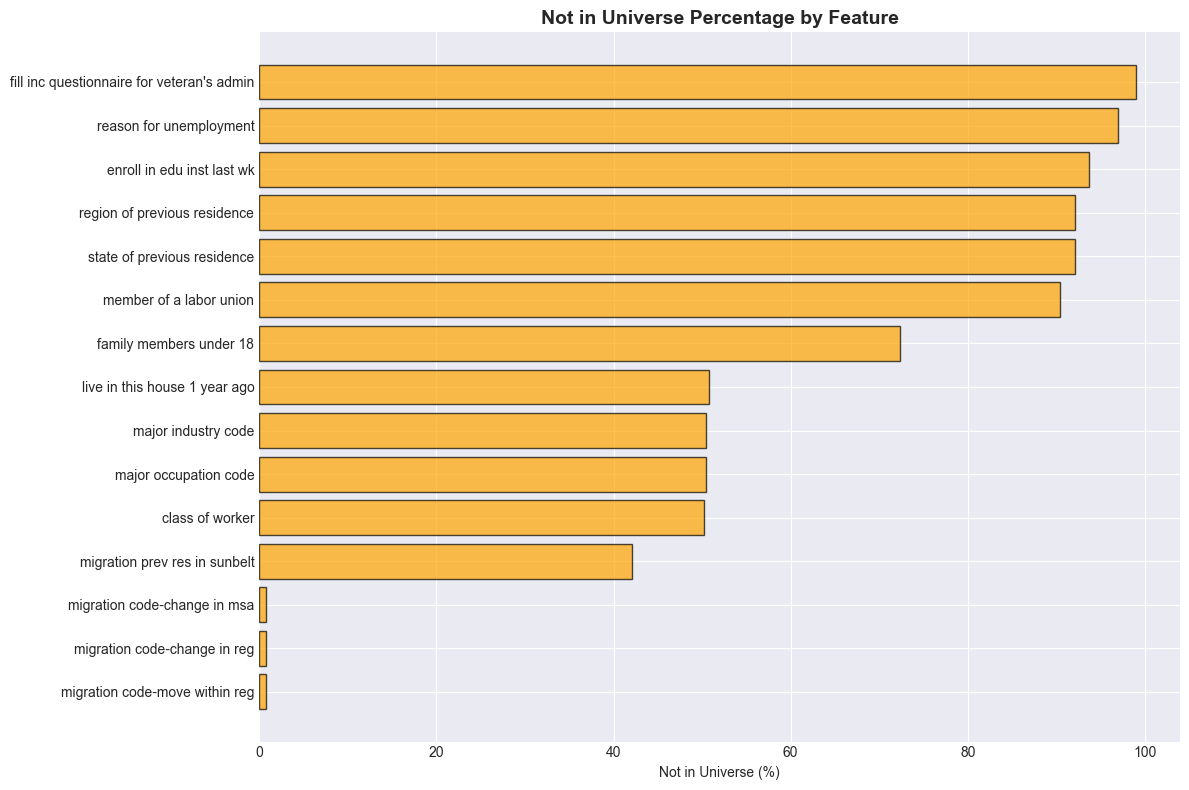

In [16]:
niu_columns = []
for col in df.columns:
    col_values = df[col].astype(str).str.strip()
    niu_count = col_values.str.contains('Not in universe', case=False, na=False).sum()
    if niu_count > 0:
        niu_pct = (niu_count / len(df)) * 100
        niu_columns.append({'Column': col, 'NIU Count': niu_count, 'NIU %': niu_pct})

if niu_columns:
    niu_df = pd.DataFrame(niu_columns).sort_values('NIU %', ascending=False)
    print(f'Columns with "Not in universe" values: {len(niu_df)}')
    print(f'\n{niu_df.to_string(index=False)}')
    
    plt.figure(figsize=(12, 8))
    plt.barh(niu_df['Column'], niu_df['NIU %'], color='orange', edgecolor='black', alpha=0.7)
    plt.xlabel('Not in Universe (%)')
    plt.title('Not in Universe Percentage by Feature', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 14. Detailed Industry Recode vs Major Industry Code

Compare detailed numeric industry recodes with major industry categories to determine which provides better interpretability. Detailed recodes lack data dictionary while major codes have meaningful names.

Key Insights: Major codes offer clearer picture with already binned categories.

DETAILED INDUSTRY RECODE ANALYSIS

Unique codes: 52
Range: 0 to 51
Code 0 percentage: 50.5%

Top 15 Codes:
  Code 0: 100,684 (50.46%)
  Code 33: 17,070 (8.56%)
  Code 43: 8,283 (4.15%)
  Code 4: 5,984 (3.00%)
  Code 42: 4,683 (2.35%)
  Code 45: 4,482 (2.25%)
  Code 29: 4,209 (2.11%)
  Code 37: 4,022 (2.02%)
  Code 41: 3,964 (1.99%)
  Code 32: 3,596 (1.80%)
  Code 35: 3,380 (1.69%)
  Code 39: 2,937 (1.47%)
  Code 34: 2,765 (1.39%)
  Code 44: 2,549 (1.28%)
  Code 2: 2,196 (1.10%)


MAJOR INDUSTRY CODE ANALYSIS

Unique categories: 24
Missing values: 0

All Categories:
 1. Not in universe or children: 100,684 (50.46%)
 2. Retail trade: 17,070 (8.56%)
 3. Manufacturing-durable goods: 9,015 (4.52%)
 4. Education: 8,283 (4.15%)
 5. Manufacturing-nondurable goods: 6,897 (3.46%)
 6. Finance insurance and real estate: 6,145 (3.08%)
 7. Construction: 5,984 (3.00%)
 8. Business and repair services: 5,651 (2.83%)
 9. Medical except hospital: 4,683 (2.35%)
10. Public administration: 4,610 (2.31%)
11

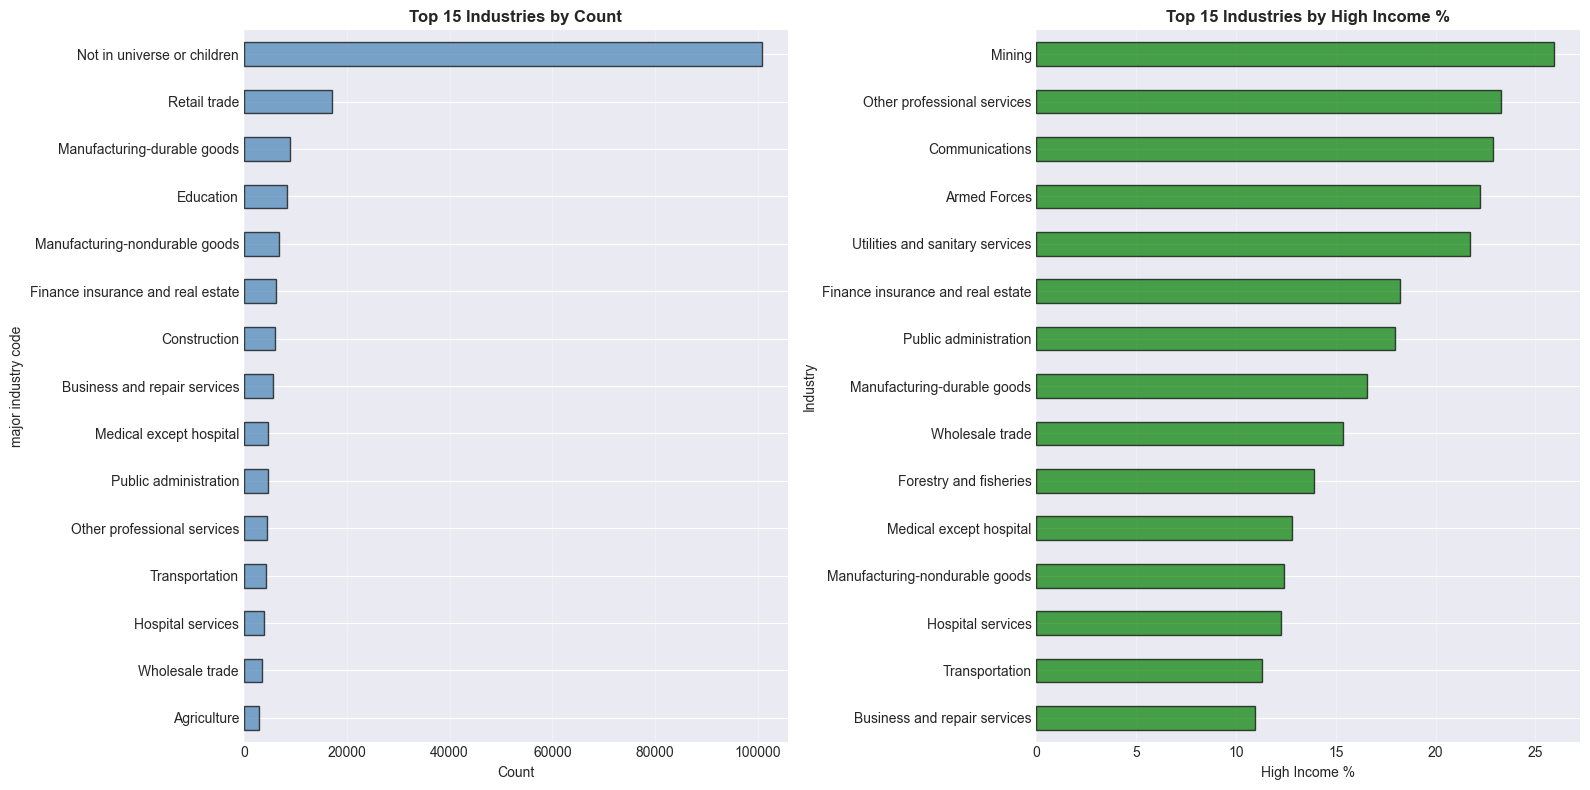

In [17]:
print('DETAILED INDUSTRY RECODE ANALYSIS')

if 'detailed industry recode' in df.columns:
    industry_recode = df['detailed industry recode']
    print(f'\nUnique codes: {industry_recode.nunique()}')
    print(f'Range: {industry_recode.min()} to {industry_recode.max()}')
    print(f'Code 0 percentage: {((industry_recode == 0).sum() / len(df) * 100):.1f}%')
    
    print(f'\nTop 15 Codes:')
    top_codes = industry_recode.value_counts().head(15)
    for code, count in top_codes.items():
        pct = (count / len(df)) * 100
        print(f'  Code {code}: {count:,} ({pct:.2f}%)')

print('\n\nMAJOR INDUSTRY CODE ANALYSIS')

if 'major industry code' in df.columns:
    major_industry = df['major industry code'].astype(str).str.strip()
    major_industry_clean = major_industry[major_industry != '?']
    
    print(f'\nUnique categories: {major_industry_clean.nunique()}')
    print(f'Missing values: {(major_industry == "?").sum():,}')
    
    print(f'\nAll Categories:')
    category_counts = major_industry_clean.value_counts()
    for i, (cat, count) in enumerate(category_counts.items(), 1):
        pct = (count / len(major_industry_clean)) * 100
        print(f'{i:2d}. {cat}: {count:,} ({pct:.2f}%)')
    
    income_by_industry = []
    for cat in category_counts.index:
        subset = df[major_industry == cat]
        high_income = subset['label_clean'].str.contains('50000\+', regex=True).sum()
        high_income_pct = (high_income / len(subset)) * 100
        income_by_industry.append({'Industry': cat[:35], 'High Income %': high_income_pct})
    
    industry_income_df = pd.DataFrame(income_by_industry).sort_values('High Income %', ascending=False)
    print(f'\nHigh Income % by Industry:')
    print(industry_income_df.to_string(index=False))
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    category_counts.head(15).plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].set_title('Top 15 Industries by Count', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Count')
    axes[0].invert_yaxis()
    axes[0].grid(alpha=0.3, axis='x')
    
    industry_income_df.head(15).plot(x='Industry', y='High Income %', kind='barh', ax=axes[1], 
                                      color='green', edgecolor='black', alpha=0.7, legend=False)
    axes[1].set_title('Top 15 Industries by High Income %', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('High Income %')
    axes[1].invert_yaxis()
    axes[1].grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

## 15. Detailed Occupation Recode vs Major Occupation Code

Compare detailed numeric occupation recodes with major occupation categories to determine which provides better interpretability. 

Key Insights: Similar to industry analysis, major codes offer clearer picture with already binned categories.

DETAILED OCCUPATION RECODE ANALYSIS

Unique codes: 47
Range: 0 to 46
Code 0 percentage: 50.5%

Top 15 Codes:
  Code 0: 100,684 (50.46%)
  Code 2: 8,756 (4.39%)
  Code 26: 7,887 (3.95%)
  Code 19: 5,413 (2.71%)
  Code 29: 5,105 (2.56%)
  Code 36: 4,145 (2.08%)
  Code 34: 4,025 (2.02%)
  Code 10: 3,683 (1.85%)
  Code 16: 3,445 (1.73%)
  Code 23: 3,392 (1.70%)
  Code 12: 3,340 (1.67%)
  Code 33: 3,325 (1.67%)
  Code 3: 3,195 (1.60%)
  Code 35: 3,168 (1.59%)
  Code 38: 3,003 (1.51%)


MAJOR OCCUPATION CODE ANALYSIS

Unique categories: 15
Missing values: 0

All Categories:
 1. Not in universe: 100,684 (50.46%)
 2. Adm support including clerical: 14,837 (7.44%)
 3. Professional specialty: 13,940 (6.99%)
 4. Executive admin and managerial: 12,495 (6.26%)
 5. Other service: 12,099 (6.06%)
 6. Sales: 11,783 (5.91%)
 7. Precision production craft & repair: 10,518 (5.27%)
 8. Machine operators assmblrs & inspctrs: 6,379 (3.20%)
 9. Handlers equip cleaners etc: 4,127 (2.07%)
10. Transportation and

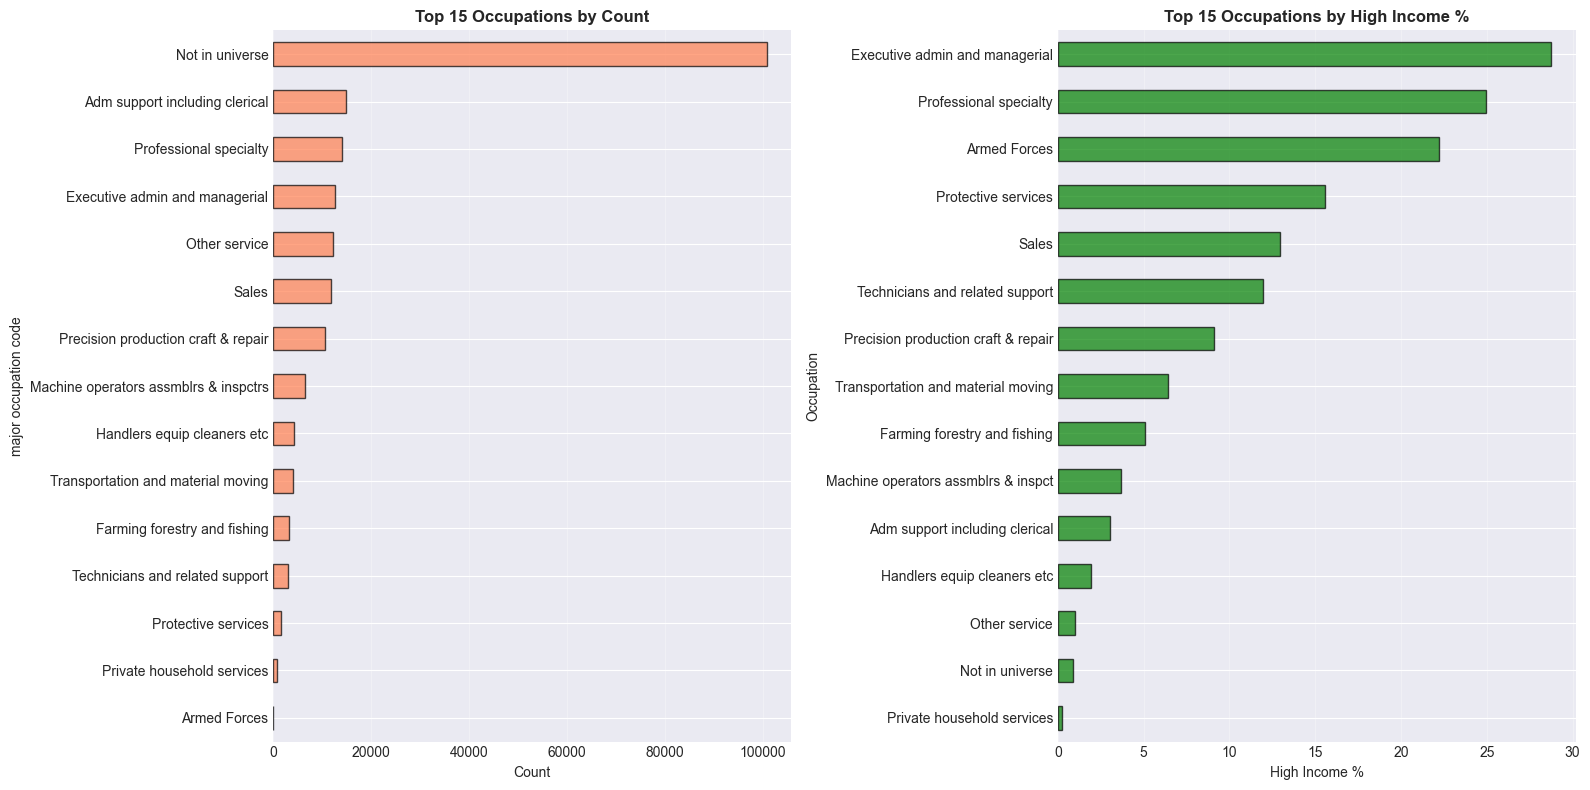

In [18]:
print('DETAILED OCCUPATION RECODE ANALYSIS')

if 'detailed occupation recode' in df.columns:
    occupation_recode = df['detailed occupation recode']
    print(f'\nUnique codes: {occupation_recode.nunique()}')
    print(f'Range: {occupation_recode.min()} to {occupation_recode.max()}')
    print(f'Code 0 percentage: {((occupation_recode == 0).sum() / len(df) * 100):.1f}%')
    
    print(f'\nTop 15 Codes:')
    top_codes = occupation_recode.value_counts().head(15)
    for code, count in top_codes.items():
        pct = (count / len(df)) * 100
        print(f'  Code {code}: {count:,} ({pct:.2f}%)')

print('\n\nMAJOR OCCUPATION CODE ANALYSIS')

if 'major occupation code' in df.columns:
    major_occupation = df['major occupation code'].astype(str).str.strip()
    major_occupation_clean = major_occupation[major_occupation != '?']
    
    print(f'\nUnique categories: {major_occupation_clean.nunique()}')
    print(f'Missing values: {(major_occupation == "?").sum():,}')
    
    print(f'\nAll Categories:')
    category_counts = major_occupation_clean.value_counts()
    for i, (cat, count) in enumerate(category_counts.items(), 1):
        pct = (count / len(major_occupation_clean)) * 100
        print(f'{i:2d}. {cat}: {count:,} ({pct:.2f}%)')
    
    income_by_occupation = []
    for cat in category_counts.index:
        subset = df[major_occupation == cat]
        high_income = subset['label_clean'].str.contains('50000\+', regex=True).sum()
        high_income_pct = (high_income / len(subset)) * 100
        income_by_occupation.append({'Occupation': cat[:35], 'High Income %': high_income_pct})
    
    occupation_income_df = pd.DataFrame(income_by_occupation).sort_values('High Income %', ascending=False)
    print(f'\nHigh Income % by Occupation:')
    print(occupation_income_df.to_string(index=False))
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    category_counts.head(15).plot(kind='barh', ax=axes[0], color='coral', edgecolor='black', alpha=0.7)
    axes[0].set_title('Top 15 Occupations by Count', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Count')
    axes[0].invert_yaxis()
    axes[0].grid(alpha=0.3, axis='x')
    
    occupation_income_df.head(15).plot(x='Occupation', y='High Income %', kind='barh', ax=axes[1], 
                                        color='green', edgecolor='black', alpha=0.7, legend=False)
    axes[1].set_title('Top 15 Occupations by High Income %', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('High Income %')
    axes[1].invert_yaxis()
    axes[1].grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()